In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
# -----------------------------
# 1. Synthetic data
# -----------------------------
np.random.seed(42)
n_samples = 100

# Class 0 centered at (2,2)
X0 = np.random.randn(n_samples, 2) + np.array([2, 2])
y0 = np.zeros(n_samples)

# Class 1 centered at (6,6)
X1 = np.random.randn(n_samples, 2) + np.array([6, 6])
y1 = np.ones(n_samples)

# Combine and shuffle
X = np.vstack((X0, X1))
y = np.hstack((y0, y1))
perm = np.random.permutation(len(y))
X, y = X[perm], y[perm]

In [4]:
print(X.shape, y.shape)

(200, 2) (200,)


In [4]:
# -----------------------------
# 2. Train / validation / test split
# -----------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [5]:
# -----------------------------
# 3. Build pipeline (scaler + logistic regression)
# -----------------------------
pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(max_iter=10000, solver="lbfgs")),
    ]
)

In [6]:
# -----------------------------
# 4. Hyperparameter tuning (C = 1/lambda)
# -----------------------------
param_grid = {"logreg__C": np.logspace(-4, 4, 20), "logreg__penalty": ["l2"]}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,  # 5-fold CV
    n_jobs=-1,
    verbose=1,
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,estimator,Pipeline(step...iter=10000))])
,param_grid,"{'logreg__C': array([1.0000...00000000e+04]), 'logreg__penalty': ['l2']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [7]:
# -----------------------------
# 5. Best model and λ
# -----------------------------
print("Best λ equivalent (1/C):", 1 / grid.best_params_["logreg__C"])
print("Best C value:", grid.best_params_["logreg__C"])
print("Best CV score:", grid.best_score_)

best_model = grid.best_estimator_

Best λ equivalent (1/C): 10000.0
Best C value: 0.0001
Best CV score: 0.9928571428571429


In [8]:
# -----------------------------
# 6. Evaluate on validation and test sets
# -----------------------------
for split, X_s, y_s in [("Validation", X_val, y_val), ("Test", X_test, y_test)]:
    y_pred = best_model.predict(X_s)
    print(f"\n{split} Accuracy:", accuracy_score(y_s, y_pred))
    print(f"{split} Classification Report:\n", classification_report(y_s, y_pred))
    print(f"{split} Confusion Matrix:\n", confusion_matrix(y_s, y_pred))


Validation Accuracy: 1.0
Validation Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        15
         1.0       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

Validation Confusion Matrix:
 [[15  0]
 [ 0 15]]

Test Accuracy: 1.0
Test Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        15
         1.0       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

Test Confusion Matrix:
 [[15  0]
 [ 0 15]]


In [9]:
# -----------------------------
# 7. Access weights and intercept
# -----------------------------
logreg = best_model.named_steps["logreg"]
print("\nModel coefficients:", logreg.coef_)
print("Model intercept:", logreg.intercept_)


Model coefficients: [[0.00639838 0.00627843]]
Model intercept: [1.4746142e-11]


In [11]:
logreg = grid.best_estimator_.named_steps["logreg"]
print(logreg.coef_)
print(logreg.intercept_)

[[0.00639838 0.00627843]]
[1.4746142e-11]


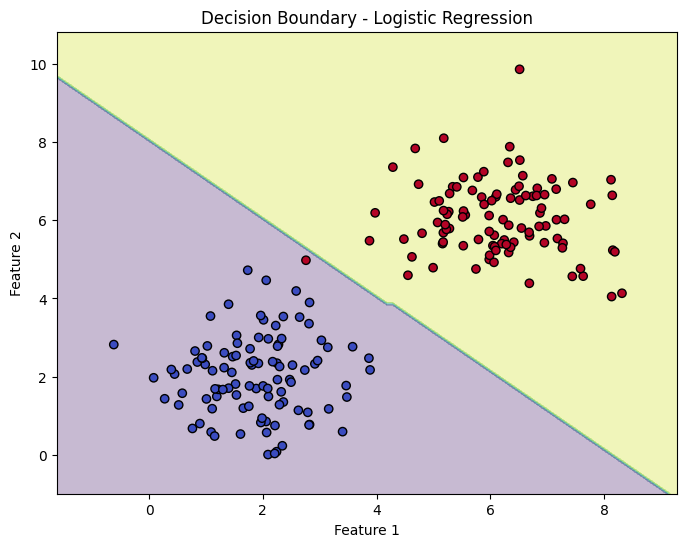

In [10]:
# -----------------------------
# 8. Plot decision boundary
# -----------------------------
h = 0.1
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = best_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k", cmap=plt.cm.coolwarm)
plt.title("Decision Boundary - Logistic Regression")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [5]:
lambdas = np.logspace(-3, 3, 10)  # λ values from 0.001 to 1000
weight_norms = []

In [6]:
for lam in lambdas:
    # LogisticRegression in scikit-learn uses C = 1 / λ
    pipe = Pipeline(
        [
            ("scaler", StandardScaler()),
            (
                "logreg",
                LogisticRegression(
                    penalty="l2", C=1 / lam, solver="lbfgs", max_iter=10000
                ),
            ),
        ]
    )
    pipe.fit(X, y)
    w = pipe.named_steps["logreg"].coef_[0]
    weight_norms.append(np.linalg.norm(w))  # magnitude of weight vector

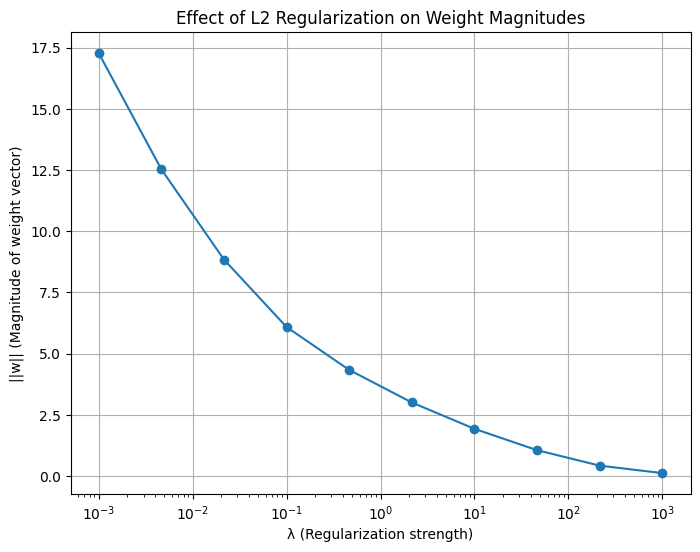

In [ ]:
# Plot
plt.figure(figsize=(8, 6))
plt.semilogx(lambdas, weight_norms, marker="o")
plt.xlabel("λ (Regularization strength)")
plt.ylabel("||w|| (Magnitude of weight vector)")
plt.title("Effect of L2 Regularization on Weight Magnitudes")
plt.grid(True)
plt.show()

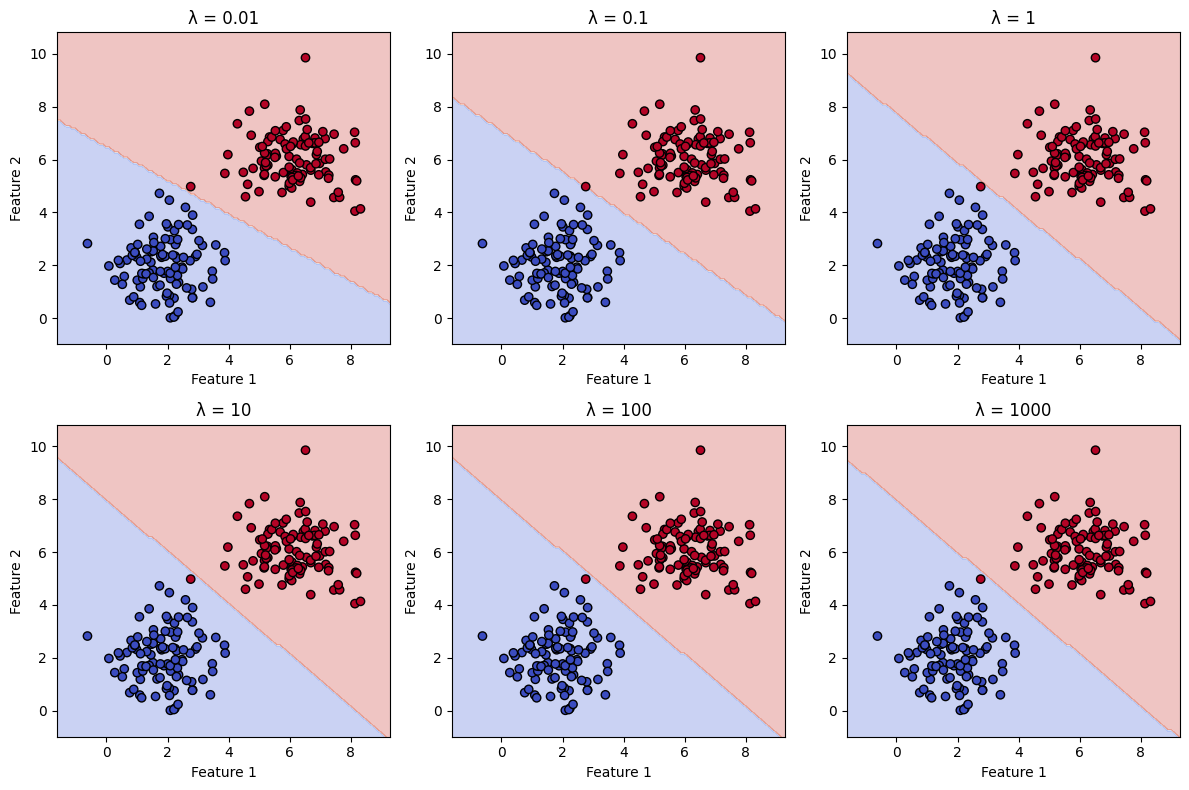

In [9]:
# Plot decision boundaries for different lambda values
# λ values to visualize
lambdas = [0.01, 0.1, 1, 10, 100, 1000]
plt.close("all")
plt.figure(figsize=(12, 8))

for i, lam in enumerate(lambdas, 1):
    # Build pipeline
    pipe = Pipeline(
        [
            ("scaler", StandardScaler()),
            (
                "logreg",
                LogisticRegression(
                    penalty="l2", C=1 / lam, solver="lbfgs", max_iter=10000
                ),
            ),
        ]
    )
    pipe.fit(X, y)

    # Create grid for plotting
    h = 0.1
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = pipe.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot
    plt.subplot(2, 3, i)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k", cmap=plt.cm.coolwarm)
    plt.title(f"λ = {lam}")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

plt.tight_layout()
plt.show()

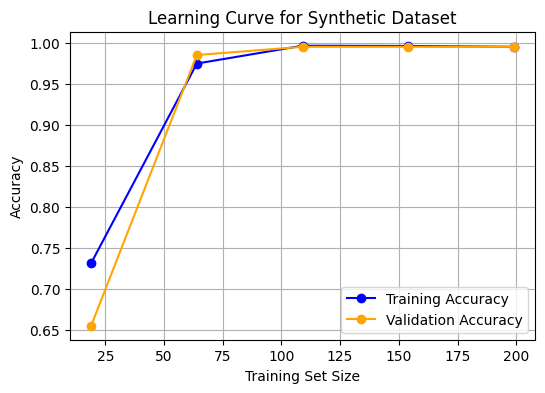

In [12]:
from sklearn.model_selection import learning_curve, LeaveOneOut

train_sizes, train_scores, val_scores = learning_curve(
    estimator=pipe,
    X=X,
    y=y,
    # train_sizes=np.linspace(0.1, 1.0, 6),
    cv=LeaveOneOut(),  # small dataset, so use LOOCV
    scoring="accuracy",
    shuffle=True,
    random_state=42,
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_mean, "o-", color="blue", label="Training Accuracy")
plt.plot(train_sizes, val_mean, "o-", color="orange", label="Validation Accuracy")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Synthetic Dataset")
plt.legend()
plt.grid(True)
plt.show()